# PatchTST

The PatchTST model is an efficient Transformer-based model for multivariate time series forecasting.

It is based on two key components:
- segmentation of time series into windows (patches) which are served as input tokens to Transformer
- channel-independence. where each channel contains a single univariate time series.

**References**<br>
- [Nie, Y., Nguyen, N. H., Sinthong, P., & Kalagnanam, J. (2022). "A Time Series is Worth 64 Words: Long-term Forecasting with Transformers"](https://arxiv.org/pdf/2211.14730.pdf)<br>

![Figure 1. PatchTST.](imgs_models/patchtst.png)

In [42]:
#| export
import sys
import os
sys.path.append(os.path.dirname(sys.path[0]))

import math
import numpy as np
from typing import Optional #, Any, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F


from neuralforecast.common._base_windows import BaseWindows
from neuralforecast.losses.pytorch import MAE, MSE

print(torch.__version__)
print(torch.cuda.is_available())

2.0.1+cu118
True


## 1. Backbone

### Auxiliary Functions

In [43]:
#| export
class Transpose(nn.Module):
    def __init__(self, *dims, contiguous=False): 
        super().__init__()
        self.dims, self.contiguous = dims, contiguous
    def forward(self, x):
        if self.contiguous: return x.transpose(*self.dims).contiguous()
        else: return x.transpose(*self.dims)

def get_activation_fn(activation):
    if callable(activation): return activation()
    elif activation.lower() == "relu": return nn.ReLU()
    elif activation.lower() == "gelu": return nn.GELU()
    raise ValueError(f'{activation} is not available. You can use "relu", "gelu", or a callable') 

### Positional Encoding

In [44]:
#| export
def PositionalEncoding(q_len, hidden_size, normalize=True):
    pe = torch.zeros(q_len, hidden_size)
    position = torch.arange(0, q_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, hidden_size, 2) * -(math.log(10000.0) / hidden_size))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    if normalize:
        pe = pe - pe.mean()
        pe = pe / (pe.std() * 10)
    return pe

SinCosPosEncoding = PositionalEncoding

def Coord2dPosEncoding(q_len, hidden_size, exponential=False, normalize=True, eps=1e-3):
    x = .5 if exponential else 1
    i = 0
    for i in range(100):
        cpe = 2 * (torch.linspace(0, 1, q_len).reshape(-1, 1) ** x) * (torch.linspace(0, 1, hidden_size).reshape(1, -1) ** x) - 1
        if abs(cpe.mean()) <= eps: break
        elif cpe.mean() > eps: x += .001
        else: x -= .001
        i += 1
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / (cpe.std() * 10)
    return cpe

def Coord1dPosEncoding(q_len, exponential=False, normalize=True):
    cpe = (2 * (torch.linspace(0, 1, q_len).reshape(-1, 1)**(.5 if exponential else 1)) - 1)
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / (cpe.std() * 10)
    return cpe

def positional_encoding(pe, learn_pe, q_len, hidden_size):
    # Positional encoding
    if pe == None:
        W_pos = torch.empty((q_len, hidden_size)) # pe = None and learn_pe = False can be used to measure impact of pe
        nn.init.uniform_(W_pos, -0.02, 0.02)
        learn_pe = False
    elif pe == 'zero':
        W_pos = torch.empty((q_len, 1))
        nn.init.uniform_(W_pos, -0.02, 0.02)
    elif pe == 'zeros':
        W_pos = torch.empty((q_len, hidden_size))
        nn.init.uniform_(W_pos, -0.02, 0.02)
    elif pe == 'normal' or pe == 'gauss':
        W_pos = torch.zeros((q_len, 1))
        torch.nn.init.normal_(W_pos, mean=0.0, std=0.1)
    elif pe == 'uniform':
        W_pos = torch.zeros((q_len, 1))
        nn.init.uniform_(W_pos, a=0.0, b=0.1)
    elif pe == 'lin1d': W_pos = Coord1dPosEncoding(q_len, exponential=False, normalize=True)
    elif pe == 'exp1d': W_pos = Coord1dPosEncoding(q_len, exponential=True, normalize=True)
    elif pe == 'lin2d': W_pos = Coord2dPosEncoding(q_len, hidden_size, exponential=False, normalize=True)
    elif pe == 'exp2d': W_pos = Coord2dPosEncoding(q_len, hidden_size, exponential=True, normalize=True)
    elif pe == 'sincos': W_pos = PositionalEncoding(q_len, hidden_size, normalize=True)
    else: raise ValueError(f"{pe} is not a valid pe (positional encoder. Available types: 'gauss'=='normal', \
        'zeros', 'zero', uniform', 'lin1d', 'exp1d', 'lin2d', 'exp2d', 'sincos', None.)")
    return nn.Parameter(W_pos, requires_grad=learn_pe)

### RevIN

In [45]:
#| export

# Reversible Invertible Normalization
class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True, subtract_last=False):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        if self.subtract_last:
            self.last = x[:,-1,:].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        if self.subtract_last:
            x = x + self.last
        else:
            x = x + self.mean
        return x

### mlp层

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MLPResidual(nn.Module):
    """Simple one hidden state residual network."""

    def __init__(
        self, input_dim, output_dim, hidden_dim=256, layer_norm=False, dropout_rate=0.0
    ):
        super(MLPResidual, self).__init__()
        self.lin_a = nn.Linear(input_dim, hidden_dim)
        self.lin_b = nn.Linear(hidden_dim, output_dim)
        self.lin_res = nn.Linear(input_dim, output_dim)
        self.layer_norm = layer_norm
        self.dropout = nn.Dropout(dropout_rate)

        if layer_norm:
            self.lnorm = nn.LayerNorm(output_dim)

    def forward(self, inputs):
        """Forward method."""
        h_state = F.relu(self.lin_a(inputs))
        out = self.lin_b(h_state)
        out = self.dropout(out)
        res = self.lin_res(inputs)
        if self.layer_norm:
            return self.lnorm(out + res)
        return out + res


class MLPStack(nn.Module):
    # hidden_dims = [第一层的维度，第二层的维度，...]
    def __init__(self, input_dim, output_dim, hidden_dims, layer_norm=False, dropout_rate=0.0):
        super(MLPStack, self).__init__()
        
        layers = []
        layers.append(
                MLPResidual(
                    input_dim=input_dim,
                    output_dim=hidden_dims[1],
                    hidden_dim=hidden_dims[0],
                    layer_norm=layer_norm,
                    dropout_rate=dropout_rate,
                )
            )
            
        for i, hdim in enumerate(hidden_dims[1:-1]):
            layers.append(
                MLPResidual(
                    input_dim=hdim,
                    output_dim=hidden_dims[i+1+1], # i+1 表示跳过第一个元素，i+1+1 表示hdim的下一个元素
                    hidden_dim=hdim,
                    layer_norm=layer_norm,
                    dropout_rate=dropout_rate,
                )
            )
        layers.append(
                MLPResidual(
                    input_dim=hidden_dims[-1],
                    output_dim=output_dim,
                    hidden_dim=hidden_dims[-1],
                    layer_norm=layer_norm,
                    dropout_rate=dropout_rate,
                )
            )
        
        self.model = nn.Sequential(*layers)

    def forward(self, inputs):
        return self.model(inputs)




In [47]:
#| exporti

from typing import Tuple, Optional

ACTIVATIONS = ['ReLU',
               'Softplus',
               'Tanh',
               'SELU',
               'LeakyReLU',
               'PReLU',
               'Sigmoid']

POOLING = ['MaxPool1d',
           'AvgPool1d']

class NHITSBlock(nn.Module):
    """
    NHITS block which takes a basis function as an argument.
    """
    def __init__(self, 
                 input_size: int,
                 h: int,
                 n_theta: int,
                 mlp_units: list,
                 basis: nn.Module,
                 futr_input_size: int,
                 hist_input_size: int,
                 stat_input_size: int,
                 n_pool_kernel_size: int,
                 pooling_mode: str,
                 dropout_prob: float,
                 activation: str):
        super().__init__()

        pooled_hist_size = int(np.ceil(input_size/n_pool_kernel_size))
        pooled_futr_size = int(np.ceil((input_size+h)/n_pool_kernel_size))

        input_size = pooled_hist_size + \
                     hist_input_size * pooled_hist_size + \
                     futr_input_size * pooled_futr_size + stat_input_size

        self.dropout_prob = dropout_prob
        self.futr_input_size = futr_input_size
        self.hist_input_size = hist_input_size
        self.stat_input_size = stat_input_size
        
        assert activation in ACTIVATIONS, f'{activation} is not in {ACTIVATIONS}'
        assert pooling_mode in POOLING, f'{pooling_mode} is not in {POOLING}'

        activ = getattr(nn, activation)()

        self.pooling_layer = getattr(nn, pooling_mode)(kernel_size=n_pool_kernel_size,
                                                       stride=n_pool_kernel_size, ceil_mode=True)

        # Block MLPs
        hidden_layers = [nn.Linear(in_features=input_size, 
                                   out_features=mlp_units[0][0])]
        for layer in mlp_units:
            hidden_layers.append(nn.Linear(in_features=layer[0], 
                                           out_features=layer[1]))
            hidden_layers.append(activ)

            if self.dropout_prob>0:
                #raise NotImplementedError('dropout')
                hidden_layers.append(nn.Dropout(p=self.dropout_prob))

        output_layer = [nn.Linear(in_features=mlp_units[-1][1], out_features=n_theta)]
        layers = hidden_layers + output_layer
        self.layers = nn.Sequential(*layers)
        self.basis = basis

    def forward(self, insample_y: torch.Tensor, futr_exog: torch.Tensor,
                hist_exog: torch.Tensor, stat_exog: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        # Pooling
        # Pool1d needs 3D input, (B,C,L), adding C dimension
        insample_y = insample_y.unsqueeze(1)
        insample_y = self.pooling_layer(insample_y)
        insample_y = insample_y.squeeze(1)

        # Flatten MLP inputs [B, L+H, C] -> [B, (L+H)*C]
        # Contatenate [ Y_t, | X_{t-L},..., X_{t} | F_{t-L},..., F_{t+H} | S ]
        batch_size = len(insample_y)
        if self.hist_input_size > 0:
            hist_exog = hist_exog.permute(0,2,1) # [B, L, C] -> [B, C, L]
            hist_exog = self.pooling_layer(hist_exog)
            hist_exog = hist_exog.permute(0,2,1) # [B, C, L] -> [B, L, C]
            insample_y = torch.cat(( insample_y, hist_exog.reshape(batch_size,-1) ), dim=1)

        if self.futr_input_size > 0:
            futr_exog = futr_exog.permute(0,2,1) # [B, L, C] -> [B, C, L]
            futr_exog = self.pooling_layer(futr_exog)
            futr_exog = futr_exog.permute(0,2,1) # [B, C, L] -> [B, L, C]
            insample_y = torch.cat(( insample_y, futr_exog.reshape(batch_size,-1) ), dim=1)

        if self.stat_input_size > 0:
            insample_y = torch.cat(( insample_y, stat_exog.reshape(batch_size,-1) ), dim=1)

        # Compute local projection weights and projection
        theta = self.layers(insample_y)
        backcast, forecast = self.basis(theta)
        return backcast, forecast

### 分解模块

In [48]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(nn.Module): # x: [Batch, Input length, Channel]
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

### Encoder

In [49]:
class _IdentityBasis(nn.Module):
    def __init__(self, backcast_size: int, forecast_size: int, 
                 interpolation_mode: str, out_features: int=1):
        super().__init__()
        assert (interpolation_mode in ['linear','nearest']) or ('cubic' in interpolation_mode)
        self.forecast_size = forecast_size
        self.backcast_size = backcast_size
        self.interpolation_mode = interpolation_mode
        self.out_features = out_features
 
    def forward(self, theta: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        backcast = theta[:, :self.backcast_size]
        knots = theta[:, self.backcast_size:]

        # Interpolation is performed on default dim=-1 := H
        knots = knots.reshape(len(knots), self.out_features, -1)
        if self.interpolation_mode in ['nearest', 'linear']:
            #knots = knots[:,None,:]
            forecast = F.interpolate(knots, size=self.forecast_size, mode=self.interpolation_mode)
            #forecast = forecast[:,0,:]
        elif 'cubic' in self.interpolation_mode:
            if self.out_features>1:
                raise Exception('Cubic interpolation not available with multiple outputs.')
            batch_size = len(backcast)
            knots = knots[:,None,:,:]
            forecast = torch.zeros((len(knots), self.forecast_size)).to(knots.device)
            n_batches = int(np.ceil(len(knots)/batch_size))
            for i in range(n_batches):
                forecast_i = F.interpolate(knots[i*batch_size:(i+1)*batch_size], 
                                           size=self.forecast_size, mode='bicubic')
                forecast[i*batch_size:(i+1)*batch_size] += forecast_i[:,0,0,:] # [B,None,H,H] -> [B,H]
            forecast = forecast[:,None,:] # [B,H] -> [B,None,H]

        # [B,Q,H] -> [B,H,Q]
        forecast = forecast.permute(0, 2, 1)
        return backcast, forecast

In [50]:

# | export
import matplotlib as plt
from neuralforecast.models import MLP
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss


class PatchTST_backbone(nn.Module):
    def __init__(
        self,
        c_in: int,
        c_out: int,
        transformer_input_size: int,
        input_size: int,
        h: int,
        patch_len: int,
        stride: int,
        mode: int = 3,
        max_seq_len: Optional[int] = 1024,
        n_layers: int = 3,
        hidden_size=128,
        n_heads=16,
        d_k: Optional[int] = None,
        d_v: Optional[int] = None,
        linear_hidden_size: int = 256,
        norm: str = "BatchNorm",
        attn_dropout: float = 0.0,
        dropout: float = 0.0,
        act: str = "gelu",
        key_padding_mask: str = "auto",
        padding_var: Optional[int] = None,
        attn_mask: Optional[torch.Tensor] = None,
        res_attention: bool = True,
        pre_norm: bool = False,
        store_attn: bool = False,
        pe: str = "zeros",
        learn_pe: bool = True,
        fc_dropout: float = 0.0,
        head_dropout=0,
        padding_patch=None,
        pretrain_head: bool = False,
        head_type="flatten",
        individual=False,
        revin=True,
        affine=True,
        subtract_last=False,
        futr_exog_list=None,
        hist_exog_list=None,
        stat_exog_list=None,
        decomp_kernel_size:int = 25,
        stack_types: list = ["identity"] * 3,
        n_pool_kernel_size: list = [2, 2, 1],
        n_freq_downsample: list = [4, 2, 1],
        n_blocks: list = [1] * 3, # Number of blocks for each stack.
        mlp_units: list = [[512, 512]] * 3,  # 每一个block的层数和每一层的神经元个数
        pooling_mode: str = "MaxPool1d",
        interpolation_mode: str = "linear",
        mlp_dropout=0.2,
        mlp_activation="ReLU",
    ):
        super().__init__()

        self.h = h
        self.mode = mode
        self.decompsition = series_decomp(decomp_kernel_size)
        self.transformer_input_size = transformer_input_size

        num_layers = 6
        self.linearEncoder = nn.Linear(input_size, h)
        self.output_layer = MLPStack(
            input_dim=h + h, hidden_dims=[hidden_size] * num_layers, output_dim=h
        )  # 输入是transformer 和 Linear 的输出的concat


        # mlp encoder
        
        futr_input_size = len(futr_exog_list) if futr_exog_list != None else 0
        hist_input_size = len(hist_exog_list) if hist_exog_list != None else 0
        stat_input_size = len(stat_exog_list) if stat_exog_list != None else 0

        blocks = self.create_stack(
            h=h,
            input_size=input_size,
            c_out=c_out,
            stack_types=stack_types,
            futr_input_size=futr_input_size,
            hist_input_size=hist_input_size,
            stat_input_size=stat_input_size,
            n_blocks=n_blocks,
            mlp_units=mlp_units,
            n_pool_kernel_size=n_pool_kernel_size,
            n_freq_downsample=n_freq_downsample,
            pooling_mode=pooling_mode,
            interpolation_mode=interpolation_mode,
            dropout_prob_theta=mlp_dropout,
            activation=mlp_activation,
        )
        self.blocks = torch.nn.ModuleList(blocks)

        # RevIn
        self.revin = revin
        if self.revin:
            self.revin_layer = RevIN(c_in, affine=affine, subtract_last=subtract_last)

        # Patching
        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch = padding_patch

        input_size = transformer_input_size

        patch_num = int((input_size - patch_len) / stride + 1)
        if padding_patch == "end":  # can be modified to general case
            self.padding_patch_layer = nn.ReplicationPad1d((0, stride))
            patch_num += 1

        self.patch_num = patch_num
        
        # Backbone
        self.backbone = TSTiEncoder(
            c_in,
            patch_num=patch_num,
            patch_len=patch_len,
            max_seq_len=max_seq_len,
            n_layers=n_layers,
            hidden_size=hidden_size,
            n_heads=n_heads,
            d_k=d_k,
            d_v=d_v,
            linear_hidden_size=linear_hidden_size,
            attn_dropout=attn_dropout,
            dropout=dropout,
            act=act,
            key_padding_mask=key_padding_mask,
            padding_var=padding_var,
            attn_mask=attn_mask,
            res_attention=res_attention,
            pre_norm=pre_norm,
            store_attn=store_attn,
            pe=pe,
            learn_pe=learn_pe,
        )

        # Head
        self.head_nf = hidden_size * patch_num
        self.n_vars = c_in
        self.c_out = c_out
        self.pretrain_head = pretrain_head
        self.head_type = head_type
        self.individual = individual

        # if self.pretrain_head:
        #     self.head = self.create_pretrain_head(
        #         self.head_nf, c_in, fc_dropout
        #     )  # custom head passed as a partial func with all its kwargs
        if head_type == 'pretrain':
            self.pretrain = True
            self.head = PretrainHead(hidden_size, patch_len, head_dropout) 
        elif head_type == "flatten":
            self.pretrain = False
            self.head = Flatten_Head(
                self.individual,
                self.n_vars,
                self.head_nf,
                h,
                c_out,
                head_dropout=head_dropout,
            )

    # z: [bs x nvars x seq_len]
    def forward(self, windows_batch):
     
        # Parse windows_batch
        insample_y = windows_batch["insample_y"]
        insample_mask = windows_batch["insample_mask"]
        hist_exog = windows_batch["hist_exog"]
        stat_exog = windows_batch["stat_exog"]
        futr_exog = windows_batch["futr_exog"]

        # Add dimension for channel
        x = insample_y.unsqueeze(-1)  # [Ws,L,1]

        z = x.permute(0, 2, 1)  # x: [Batch, 1, input_size]

        # norm
        if self.revin:
            z = z.permute(0, 2, 1)
            z = self.revin_layer(z, "norm")
            z = z.permute(0, 2, 1)

        # 根据预训练还是正常训练状态执行不同的forward

        if self.pretrain:
            # truncate
            z = z[:, :, -self.transformer_input_size :]

            # do patching
            if self.padding_patch == "end":
                z = self.padding_patch_layer(z)
            z = z.unfold(
                dimension=-1, size=self.patch_len, step=self.stride
            )  # z: [bs x nvars x patch_num x patch_len]
            z = z.permute(0, 1, 3, 2)  # z: [bs x nvars x patch_len x patch_num]

            # model
            z = self.backbone(z)
            # z: [bs x nvars x hidden_size x patch_num]
            z = self.head(z)  # z: [bs x nvars x h]

        else:

            # decomp
            seasonal_init, trend_init = self.decompsition(z.permute(0, 2, 1))
            seasonal_init, trend_init = seasonal_init.permute(0, 2, 1), trend_init.permute(
                0, 2, 1
            ) # [Batch, 1, input_size]

            input_z = z
            
            ### trend fit:
            z_ = trend_init
            z_ = z_.view(z_.shape[0], -1)  # （bs,seq_len)
            residuals = z_.flip(dims=(-1,)) #backcast init
            insample_mask = insample_mask.flip(dims=(-1,))
            
            forecast = z_[:, -1:, None] # Level with Naive1
            # forecast = z_[:, -1:, :] # Level with Naive1
            
            block_forecasts = [ forecast.repeat(1, self.h, 1) ]
            for i, block in enumerate(self.blocks):
                backcast, block_forecast = block(insample_y=residuals, futr_exog=futr_exog,
                                                hist_exog=hist_exog, stat_exog=stat_exog)
                residuals = (residuals + backcast) * insample_mask
                forecast = forecast + block_forecast
            z_ = forecast
            

            ### local pattern fit:

            # truncate
            z = z[:, :, -self.transformer_input_size :]
            z = torch.diff(z, dim=-1)

            # do patching
            if self.padding_patch == "end":
                z = self.padding_patch_layer(z)
            z = z.unfold(
                dimension=-1, size=self.patch_len, step=self.stride
            )  # z: [bs x nvars x patch_num x patch_len]
            z = z.permute(0, 1, 3, 2)  # z: [bs x nvars x patch_len x patch_num]
          
            # model
            z = self.backbone(z)
            # z: [bs x nvars x hidden_size x patch_num]
            z = self.head(z)  # z: [bs x nvars x h]
            
            # mode 1: transformer 2: linear 3: mix
            mode = self.mode
            if mode == 1:
                guid = False
            elif mode == 2:
                guid = False
                z = z_.permute(0, 2, 1)
            elif mode == 3:
                guid = True

            # concat
            if guid:
                z = z.reshape(z.shape[0], -1)  # （bs,pred_len)
                z_ = z_.reshape(z_.shape[0], -1)  # （bs,pred_len)
                z = self.output_layer(torch.cat((z, z_), dim=1))
                # z = [bs x h]
                z = z.unsqueeze(1)
            
                # z = input_z + z + z_.permute(0, 2, 1)
            
            
            input_z = self.linearEncoder(input_z)   
            z = input_z + z
        
        # denorms
        if self.revin:
            z = z.permute(0, 2, 1)
            z = self.revin_layer(z, "denorm")
            z = z.permute(0, 2, 1)

        return z

    def create_pretrain_head(self, head_nf, vars, dropout):
        return nn.Sequential(nn.Dropout(dropout), nn.Conv1d(head_nf, vars, 1))
    
    def create_stack(
        self,
        h,
        input_size,
        c_out,
        stack_types,
        n_blocks,
        mlp_units,
        n_pool_kernel_size,
        n_freq_downsample,
        pooling_mode,
        interpolation_mode,
        dropout_prob_theta,
        activation,
        futr_input_size,
        hist_input_size,
        stat_input_size,
    ):
        block_list = []
        for i in range(len(stack_types)):
            for block_id in range(n_blocks[i]):
                assert (
                    stack_types[i] == "identity"
                ), f"Block type {stack_types[i]} not found!"

                n_theta = input_size + c_out * max(h // n_freq_downsample[i], 1)
                basis = _IdentityBasis(
                    backcast_size=input_size,
                    forecast_size=h,
                    out_features=c_out,
                    interpolation_mode=interpolation_mode,
                )

                nbeats_block = NHITSBlock(
                    h=h,
                    input_size=input_size,
                    futr_input_size=futr_input_size,
                    hist_input_size=hist_input_size,
                    stat_input_size=stat_input_size,
                    n_theta=n_theta,
                    mlp_units=mlp_units,
                    n_pool_kernel_size=n_pool_kernel_size[i],
                    pooling_mode=pooling_mode,
                    basis=basis,
                    dropout_prob=dropout_prob_theta,
                    activation=activation,
                )

                # Select type of evaluation and apply it to all layers of block
                block_list.append(nbeats_block)

        return block_list


class Flatten_Head(nn.Module):
    def __init__(self, individual, n_vars, nf, h, c_out, head_dropout=0):
        super().__init__()

        self.individual = individual
        self.n_vars = n_vars
        self.c_out = c_out

        if self.individual:
            self.linears = nn.ModuleList()
            self.dropouts = nn.ModuleList()
            self.flattens = nn.ModuleList()
            for i in range(self.n_vars):
                self.flattens.append(nn.Flatten(start_dim=-2))
                self.linears.append(nn.Linear(nf, h * c_out))
                self.dropouts.append(nn.Dropout(head_dropout))
        else:
            self.flatten = nn.Flatten(start_dim=-2)
            self.linear = nn.Linear(nf, h * c_out)
            self.dropout = nn.Dropout(head_dropout)

    def forward(self, x):  # x: [bs x nvars x hidden_size x patch_num]
        if self.individual:
            x_out = []
            for i in range(self.n_vars):
                z = self.flattens[i](x[:, i, :, :])  # z: [bs x hidden_size * patch_num]
                z = self.linears[i](z)  # z: [bs x h]
                z = self.dropouts[i](z)
                x_out.append(z)
            x = torch.stack(x_out, dim=1)  # x: [bs x nvars x h]
        else:
            x = self.flatten(x)
            x = self.linear(x)
            x = self.dropout(x)
        return x


class PretrainHead(nn.Module):
    def __init__(self, d_model, patch_len, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(d_model, patch_len)

    def forward(self, x):
        """
        x: tensor [bs x nvars x d_model x num_patch]
        output: tensor [bs x nvars x num_patch x patch_len]
        """

        x = x.transpose(2,3)                     # [bs x nvars x num_patch x d_model]
        x = self.linear( self.dropout(x) )      # [bs x nvars x num_patch x patch_len]
        x = x.permute(0,2,1,3)                  # [bs x num_patch x nvars x patch_len]
        return x


class TSTiEncoder(nn.Module):  # i means channel-independent
    def __init__(
        self,
        c_in,
        patch_num,
        patch_len,
        max_seq_len=1024,
        n_layers=3,
        hidden_size=128,
        n_heads=16,
        d_k=None,
        d_v=None,
        linear_hidden_size=256,
        norm="BatchNorm",
        attn_dropout=0.0,
        dropout=0.0,
        act="gelu",
        store_attn=False,
        key_padding_mask="auto",
        padding_var=None,
        attn_mask=None,
        res_attention=True,
        pre_norm=False,
        pe="zeros",
        learn_pe=True,
    ):
        super().__init__()

        self.patch_num = patch_num
        self.patch_len = patch_len

        # Input encoding
        q_len = patch_num
        self.W_P = nn.Linear(
            patch_len, hidden_size
        )  # Eq 1: projection of feature vectors onto a d-dim vector space
        self.seq_len = q_len

        # Positional encoding
        self.W_pos = positional_encoding(pe, learn_pe, q_len, hidden_size)

        # Residual dropout
        self.dropout = nn.Dropout(dropout)

        # Encoder
        self.encoder = TSTEncoder(
            q_len,
            hidden_size,
            n_heads,
            d_k=d_k,
            d_v=d_v,
            linear_hidden_size=linear_hidden_size,
            norm=norm,
            attn_dropout=attn_dropout,
            dropout=dropout,
            pre_norm=pre_norm,
            activation=act,
            res_attention=res_attention,
            n_layers=n_layers,
            store_attn=store_attn,
        )

    def forward(self, x) -> torch.Tensor:  # x: [bs x nvars x patch_len x patch_num]
        n_vars = x.shape[1]
        # Input encoding
        x = x.permute(0, 1, 3, 2)  # x: [bs x nvars x patch_num x patch_len]
        x = self.W_P(x)  # x: [bs x nvars x patch_num x hidden_size]

        u = torch.reshape(
            x, (x.shape[0] * x.shape[1], x.shape[2], x.shape[3])
        )  # u: [bs * nvars x patch_num x hidden_size]
        u = self.dropout(u + self.W_pos)  # u: [bs * nvars x patch_num x hidden_size]

        # Encoder
        z = self.encoder(u)  # z: [bs * nvars x patch_num x hidden_size]
        z = torch.reshape(
            z, (-1, n_vars, z.shape[-2], z.shape[-1])
        )  # z: [bs x nvars x patch_num x hidden_size]
        z = z.permute(0, 1, 3, 2)  # z: [bs x nvars x hidden_size x patch_num]

        return z


class TSTEncoder(nn.Module):
    def __init__(
        self,
        q_len,
        hidden_size,
        n_heads,
        d_k=None,
        d_v=None,
        linear_hidden_size=None,
        norm="BatchNorm",
        attn_dropout=0.0,
        dropout=0.0,
        activation="gelu",
        res_attention=False,
        n_layers=1,
        pre_norm=False,
        store_attn=False,
    ):
        super().__init__()

        self.layers = nn.ModuleList(
            [
                TSTEncoderLayer(
                    q_len,
                    hidden_size,
                    n_heads=n_heads,
                    d_k=d_k,
                    d_v=d_v,
                    linear_hidden_size=linear_hidden_size,
                    norm=norm,
                    attn_dropout=attn_dropout,
                    dropout=dropout,
                    activation=activation,
                    res_attention=res_attention,
                    pre_norm=pre_norm,
                    store_attn=store_attn,
                )
                for i in range(n_layers)
            ]
        )
        self.res_attention = res_attention

    def forward(
        self,
        src: torch.Tensor,
        key_padding_mask: Optional[torch.Tensor] = None,
        attn_mask: Optional[torch.Tensor] = None,
    ):
        output = src
        scores = None
        if self.res_attention:
            for mod in self.layers:
                output, scores = mod(
                    output,
                    prev=scores,
                    key_padding_mask=key_padding_mask,
                    attn_mask=attn_mask,
                )
            return output
        else:
            for mod in self.layers:
                output = mod(
                    output, key_padding_mask=key_padding_mask, attn_mask=attn_mask
                )
            return output


class TSTEncoderLayer(nn.Module):
    def __init__(
        self,
        q_len,
        hidden_size,
        n_heads,
        d_k=None,
        d_v=None,
        linear_hidden_size=256,
        store_attn=False,
        norm="BatchNorm",
        attn_dropout=0,
        dropout=0.0,
        bias=True,
        activation="gelu",
        res_attention=False,
        pre_norm=False,
    ):
        super().__init__()
        assert (
            not hidden_size % n_heads
        ), f"hidden_size ({hidden_size}) must be divisible by n_heads ({n_heads})"
        d_k = hidden_size // n_heads if d_k is None else d_k
        d_v = hidden_size // n_heads if d_v is None else d_v

        # Multi-Head attention
        self.res_attention = res_attention
        self.self_attn = _MultiheadAttention(
            hidden_size,
            n_heads,
            d_k,
            d_v,
            attn_dropout=attn_dropout,
            proj_dropout=dropout,
            res_attention=res_attention,
        )

        # Add & Norm
        self.dropout_attn = nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_attn = nn.Sequential(
                Transpose(1, 2), nn.BatchNorm1d(hidden_size), Transpose(1, 2)
            )
        else:
            self.norm_attn = nn.LayerNorm(hidden_size)

        # Position-wise Feed-Forward
        self.ff = nn.Sequential(
            nn.Linear(hidden_size, linear_hidden_size, bias=bias),
            get_activation_fn(activation),
            nn.Dropout(dropout),
            nn.Linear(linear_hidden_size, hidden_size, bias=bias),
        )

        # Add & Norm
        self.dropout_ffn = nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_ffn = nn.Sequential(
                Transpose(1, 2), nn.BatchNorm1d(hidden_size), Transpose(1, 2)
            )
        else:
            self.norm_ffn = nn.LayerNorm(hidden_size)

        self.pre_norm = pre_norm
        self.store_attn = store_attn

    def forward(
        self,
        src: torch.Tensor,
        prev: Optional[torch.Tensor] = None,
        key_padding_mask: Optional[torch.Tensor] = None,
        attn_mask: Optional[torch.Tensor] = None,
    ):  # -> Tuple[torch.Tensor, Any]:
        # Multi-Head attention sublayer
        if self.pre_norm:
            src = self.norm_attn(src)
        ## Multi-Head attention
        if self.res_attention:
            src2, attn, scores = self.self_attn(
                src,
                src,
                src,
                prev,
                key_padding_mask=key_padding_mask,
                attn_mask=attn_mask,
            )
        else:
            src2, attn = self.self_attn(
                src, src, src, key_padding_mask=key_padding_mask, attn_mask=attn_mask
            )
        if self.store_attn:
            self.attn = attn
        ## Add & Norm
        src = src + self.dropout_attn(
            src2
        )  # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_attn(src)

        # Feed-forward sublayer
        if self.pre_norm:
            src = self.norm_ffn(src)
        ## Position-wise Feed-Forward
        src2 = self.ff(src)
        ## Add & Norm
        src = src + self.dropout_ffn(
            src2
        )  # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_ffn(src)

        if self.res_attention:
            return src, scores
        else:
            return src


class _MultiheadAttention(nn.Module):
    def __init__(
        self,
        hidden_size,
        n_heads,
        d_k=None,
        d_v=None,
        res_attention=False,
        attn_dropout=0.0,
        proj_dropout=0.0,
        qkv_bias=True,
        lsa=False,
    ):
        """
        Multi Head Attention Layer
        Input shape:
            Q:       [batch_size (bs) x max_q_len x hidden_size]
            K, V:    [batch_size (bs) x q_len x hidden_size]
            mask:    [q_len x q_len]
        """
        super().__init__()
        d_k = hidden_size // n_heads if d_k is None else d_k
        d_v = hidden_size // n_heads if d_v is None else d_v

        self.n_heads, self.d_k, self.d_v = n_heads, d_k, d_v

        self.W_Q = nn.Linear(hidden_size, d_k * n_heads, bias=qkv_bias)
        self.W_K = nn.Linear(hidden_size, d_k * n_heads, bias=qkv_bias)
        self.W_V = nn.Linear(hidden_size, d_v * n_heads, bias=qkv_bias)

        # Scaled Dot-Product Attention (multiple heads)
        self.res_attention = res_attention
        self.sdp_attn = _ScaledDotProductAttention(
            hidden_size,
            n_heads,
            attn_dropout=attn_dropout,
            res_attention=self.res_attention,
            lsa=lsa,
        )

        # Poject output
        self.to_out = nn.Sequential(
            nn.Linear(n_heads * d_v, hidden_size), nn.Dropout(proj_dropout)
        )

    def forward(
        self,
        Q: torch.Tensor,
        K: Optional[torch.Tensor] = None,
        V: Optional[torch.Tensor] = None,
        prev: Optional[torch.Tensor] = None,
        key_padding_mask: Optional[torch.Tensor] = None,
        attn_mask: Optional[torch.Tensor] = None,
    ):
        bs = Q.size(0)
        if K is None:
            K = Q
        if V is None:
            V = Q

        # Linear (+ split in multiple heads)
        q_s = (
            self.W_Q(Q).view(bs, -1, self.n_heads, self.d_k).transpose(1, 2)
        )  # q_s    : [bs x n_heads x max_q_len x d_k]
        k_s = (
            self.W_K(K).view(bs, -1, self.n_heads, self.d_k).permute(0, 2, 3, 1)
        )  # k_s    : [bs x n_heads x d_k x q_len] - transpose(1,2) + transpose(2,3)
        v_s = (
            self.W_V(V).view(bs, -1, self.n_heads, self.d_v).transpose(1, 2)
        )  # v_s    : [bs x n_heads x q_len x d_v]

        # Apply Scaled Dot-Product Attention (multiple heads)
        if self.res_attention:
            output, attn_weights, attn_scores = self.sdp_attn(
                q_s,
                k_s,
                v_s,
                prev=prev,
                key_padding_mask=key_padding_mask,
                attn_mask=attn_mask,
            )
        else:
            output, attn_weights = self.sdp_attn(
                q_s, k_s, v_s, key_padding_mask=key_padding_mask, attn_mask=attn_mask
            )
        # output: [bs x n_heads x q_len x d_v], attn: [bs x n_heads x q_len x q_len], scores: [bs x n_heads x max_q_len x q_len]

        # back to the original inputs dimensions
        output = (
            output.transpose(1, 2).contiguous().view(bs, -1, self.n_heads * self.d_v)
        )  # output: [bs x q_len x n_heads * d_v]
        output = self.to_out(output)

        if self.res_attention:
            return output, attn_weights, attn_scores
        else:
            return output, attn_weights


class _ScaledDotProductAttention(nn.Module):
    """
    Scaled Dot-Product Attention module (Attention is all you need by Vaswani et al., 2017) with optional residual attention from previous layer
    (Realformer: Transformer likes residual attention by He et al, 2020) and locality self sttention (Vision Transformer for Small-Size Datasets
    by Lee et al, 2021)
    """

    def __init__(
        self, hidden_size, n_heads, attn_dropout=0.0, res_attention=False, lsa=False
    ):
        super().__init__()
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.res_attention = res_attention
        head_dim = hidden_size // n_heads
        self.scale = nn.Parameter(torch.tensor(head_dim**-0.5), requires_grad=lsa)
        self.lsa = lsa

    def forward(
        self,
        q: torch.Tensor,
        k: torch.Tensor,
        v: torch.Tensor,
        prev: Optional[torch.Tensor] = None,
        key_padding_mask: Optional[torch.Tensor] = None,
        attn_mask: Optional[torch.Tensor] = None,
    ):
        """
        Input shape:
            q               : [bs x n_heads x max_q_len x d_k]
            k               : [bs x n_heads x d_k x seq_len]
            v               : [bs x n_heads x seq_len x d_v]
            prev            : [bs x n_heads x q_len x seq_len]
            key_padding_mask: [bs x seq_len]
            attn_mask       : [1 x seq_len x seq_len]
        Output shape:
            output:  [bs x n_heads x q_len x d_v]
            attn   : [bs x n_heads x q_len x seq_len]
            scores : [bs x n_heads x q_len x seq_len]
        """

        # Scaled MatMul (q, k) - similarity scores for all pairs of positions in an input sequence
        attn_scores = (
            torch.matmul(q, k) * self.scale
        )  # attn_scores : [bs x n_heads x max_q_len x q_len]

        # Add pre-softmax attention scores from the previous layer (optional)
        if prev is not None:
            attn_scores = attn_scores + prev

        # Attention mask (optional)
        if (
            attn_mask is not None
        ):  # attn_mask with shape [q_len x seq_len] - only used when q_len == seq_len
            if attn_mask.dtype == torch.bool:
                attn_scores.masked_fill_(attn_mask, -np.inf)
            else:
                attn_scores += attn_mask

        # Key padding mask (optional)
        if (
            key_padding_mask is not None
        ):  # mask with shape [bs x q_len] (only when max_w_len == q_len)
            attn_scores.masked_fill_(
                key_padding_mask.unsqueeze(1).unsqueeze(2), -np.inf
            )

        # normalize the attention weights
        attn_weights = F.softmax(
            attn_scores, dim=-1
        )  # attn_weights   : [bs x n_heads x max_q_len x q_len]
        attn_weights = self.attn_dropout(attn_weights)

        # compute the new values given the attention weights
        output = torch.matmul(
            attn_weights, v
        )  # output: [bs x n_heads x max_q_len x d_v]

        if self.res_attention:
            return output, attn_weights, attn_scores
        else:
            return output, attn_weights

## loss

In [51]:
from typing import Optional, Union, Tuple

import math

class trendMAE(torch.nn.Module):
    """Mean Absolute Error

    Calculates Mean Absolute Error between
    `y` and `y_hat`. MAE measures the relative prediction
    accuracy of a forecasting method by calculating the
    deviation of the prediction and the true
    value at a given time and averages these devations
    over the length of the series.

    $$ \mathrm{MAE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}) = \\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} |y_{\\tau} - \hat{y}_{\\tau}| $$
    """    
    def __init__(self,kernel_size:int=25):
        super(trendMAE, self).__init__()
        self.outputsize_multiplier = 1
        self.output_names = ['']
        self.is_distribution_output = False
        self.decompsition = series_decomp(kernel_size)

    def domain_map(self, y_hat: torch.Tensor):
        """
        Univariate loss operates in dimension [B,T,H]/[B,H]
        This changes the network's output from [B,H,1]->[B,H]
        """
        return y_hat.squeeze(-1)

    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `mae`: tensor (single value).
        """
        if mask is None:
            mask = torch.ones_like(y)
        
        z = y.unsqueeze(1)
        # decomp
        seasonal_init, trend_init = self.decompsition(z.permute(0, 2, 1))
        seasonal_init, trend_init = seasonal_init.permute(0, 2, 1), trend_init.permute(
            0, 2, 1
        ) # [Batch, 1, input_size]
        
        # plt.plot(z[0][0].cpu())
        # plt.plot(trend_init[0][0].cpu())
        
        mae = torch.abs(trend_init.squeeze(1) - y_hat) * mask
        mae = torch.mean(mae)
        return mae#| export

## 2. Model

In [52]:
# | export
class MIXModel(BaseWindows):
    SAMPLING_TYPE = "windows"

    def __init__(
        self,
        h,
        input_size,
        mode=3,
        pretrain: bool = False,
        stack_types: list = ["identity", "identity", "identity"],  # ?
        n_blocks: list = [3, 3, 3],
        mlp_units: list = 3 * [[512, 512]],
        n_pool_kernel_size: list = [2, 2, 1],
        n_freq_downsample: list = [4, 2, 1],
        pooling_mode: str = "MaxPool1d",
        interpolation_mode: str = "linear",
        dropout_prob_theta=0.2,
        mlp_activation: str = "ReLU",
        transformer_input_size: int = 96,
        stat_exog_list=None,
        hist_exog_list=None,
        futr_exog_list=None,
        exclude_insample_y=False,
        encoder_layers: int = 3,
        n_heads: int = 16,
        hidden_size: int = 128,
        linear_hidden_size: int = 256,
        dropout: float = 0.2,
        fc_dropout: float = 0.2,
        head_dropout: float = 0.0,
        attn_dropout: float = 0.0,
        patch_len: int = 16,
        stride: int = 8,
        revin: bool = True,
        revin_affine: bool = False,
        revin_subtract_last: bool = True,
        activation: str = "gelu",
        res_attention: bool = True,
        batch_normalization: bool = False,
        learn_pos_embed: bool = True,
        #  loss = DistributionLoss(distribution='StudentT', level=[80, 90]),
        loss=MAE(),
        valid_loss=None,
        max_steps: int = 5000,
        learning_rate: float = 1e-3,
        num_lr_decays: int = -1,
        early_stop_patience_steps: int = -1,
        val_check_steps: int = 100,
        batch_size: int = 32,
        valid_batch_size: Optional[int] = None,
        windows_batch_size=1024,
        inference_windows_batch_size: int = 1024,
        step_size: int = 1,
        scaler_type: str = "identity",
        random_seed: int = 1,
        num_workers_loader: int = 0,
        drop_last_loader: bool = False,
        **trainer_kwargs
    ):
        super(MIXModel, self).__init__(
            h=h,
            input_size=input_size,
            hist_exog_list=hist_exog_list,
            stat_exog_list=stat_exog_list,
            futr_exog_list=futr_exog_list,
            exclude_insample_y=exclude_insample_y,
            loss=loss,
            valid_loss=valid_loss,
            max_steps=max_steps,
            learning_rate=learning_rate,
            num_lr_decays=num_lr_decays,
            early_stop_patience_steps=early_stop_patience_steps,
            val_check_steps=val_check_steps,
            batch_size=batch_size,
            valid_batch_size=valid_batch_size,
            windows_batch_size=windows_batch_size,
            inference_windows_batch_size=inference_windows_batch_size,
            step_size=step_size,
            scaler_type=scaler_type,
            num_workers_loader=num_workers_loader,
            drop_last_loader=drop_last_loader,
            random_seed=random_seed,
            **trainer_kwargs
        )
        # Asserts
        # if stat_exog_list is not None:
        #     raise Exception("PatchTST does not yet support static exogenous variables")
        # if futr_exog_list is not None:
        #     raise Exception("PatchTST does not yet support future exogenous variables")
        # if hist_exog_list is not None:
        #     raise Exception("PatchTST does not yet support historical exogenous variables")

        c_out = self.loss.outputsize_multiplier  # c_out = 1

        # Fixed hyperparameters
        c_in = 1  # Always univariate
        padding_patch = "end"  # Padding at the end
        pretrain_head = True  # No pretrained head
        norm = "BatchNorm"  # Use BatchNorm (if batch_normalization is True)
        pe = "zeros"  # Initial zeros for positional encoding
        d_k = None  # Key dimension
        d_v = None  # Value dimension
        store_attn = False  # Store attention weights
        # head_type = "flatten"  # Head type
        individual = False  # Separate heads for each time series
        max_seq_len = 1024  # Not used
        key_padding_mask = "auto"  # Not used
        padding_var = None  # Not used
        attn_mask = None  # Not used

        # pretrain
        if pretrain == True:
            head_type = "pretrain"
        else:
            head_type = "flatten"

        self.model = PatchTST_backbone(
            futr_exog_list=futr_exog_list,
            hist_exog_list=hist_exog_list,
            stat_exog_list=stat_exog_list,
            mode=mode,
            c_in=c_in,
            c_out=c_out,
            transformer_input_size=transformer_input_size,
            input_size=input_size,
            h=h,
            patch_len=patch_len,
            stride=stride,
            max_seq_len=max_seq_len,
            n_layers=encoder_layers,
            hidden_size=hidden_size,
            n_heads=n_heads,
            d_k=d_k,
            d_v=d_v,
            linear_hidden_size=linear_hidden_size,
            norm=norm,
            attn_dropout=attn_dropout,
            dropout=dropout,
            act=activation,
            key_padding_mask=key_padding_mask,
            padding_var=padding_var,
            attn_mask=attn_mask,
            res_attention=res_attention,
            pre_norm=batch_normalization,
            store_attn=store_attn,
            pe=pe,
            learn_pe=learn_pos_embed,
            fc_dropout=fc_dropout,
            head_dropout=head_dropout,
            padding_patch=padding_patch,
            pretrain_head=pretrain_head,
            head_type=head_type,
            individual=individual,
            revin=revin,
            affine=revin_affine,
            subtract_last=revin_subtract_last,
            stack_types=stack_types,
            n_blocks=n_blocks,
            mlp_units=mlp_units,
            n_pool_kernel_size=n_pool_kernel_size,
            n_freq_downsample=n_freq_downsample,
            pooling_mode=pooling_mode,
            interpolation_mode=interpolation_mode,
            mlp_dropout=dropout_prob_theta,
            mlp_activation=mlp_activation,
        )
   

    def forward(self, windows_batch):  # x: [batch, input_size]
        x = self.model(windows_batch)
        x = x.reshape(x.shape[0], self.h, -1)  # x: [Batch, h, c_out]

        # Domain map
        forecast = self.loss.domain_map(x)

        return forecast
    
    

## Usage example

In [53]:
def transfer_weights(weights_path, model, exclude_head=True):

    new_state_dict = torch.load(weights_path)

    matched_layers = 0
    unmatched_layers = []
    for name, param in model.state_dict().items():      
        if exclude_head and 'head' in name: continue
        if 'linearEncoder' in name: continue
        if 'output_layer' in name: continue
        if 'blocks' in name: continue
        
        if name in new_state_dict:      
            matched_layers += 1
            input_param = new_state_dict[name]
            if input_param.shape == param.shape: param.copy_(input_param)
            else: unmatched_layers.append(name)
        else:
            unmatched_layers.append(name)
            pass # these are weights that weren't in the original model, such as a new head
    
    print(f"{matched_layers} layers out of {len(model.state_dict().items())} layers were matched")
    print(f"{len(unmatched_layers)} layers were unmatched\n")
    if matched_layers == 0: raise Exception("No shared weight names were found between the models")
    else:
        if len(unmatched_layers) > 0:
            print(f'check unmatched_layers: {unmatched_layers}')
        else:
            print(f"weights from {weights_path} successfully transferred!\n")
    return model



In [54]:
from neuralforecast.models import LSTM, NHITS, FEDformer, PatchTST

# from ..neuralforecast.auto import AutoMixmodel
from sklearn.preprocessing import StandardScaler
from datasetsforecast.long_horizon2 import LongHorizon2, LongHorizon2Info
from neuralforecast import NeuralForecast
import pandas as pd


input_size = 512
horizon = 96
dataset = "ETTh1"
# num_samples = 20

data = pd.read_csv("../dataset/ETDataset-main/ETTh1.csv", parse_dates=["date"])
data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


In [55]:
Y_df= data[['date','OT']]
Y_df.columns = ['ds','y']
Y_df['unique_id'] = 'OT'

In [56]:
Y_df

,ds,y,unique_id
0,2016-07-01 00:00:00,30.531000,OT
1,2016-07-01 01:00:00,27.787001,OT
2,2016-07-01 02:00:00,27.787001,OT
3,2016-07-01 03:00:00,25.044001,OT
4,2016-07-01 04:00:00,21.948000,OT
...,...,...,...
17415,2018-06-26 15:00:00,10.904000,OT
17416,2018-06-26 16:00:00,11.044000,OT
17417,2018-06-26 17:00:00,10.271000,OT
17418,2018-06-26 18:00:00,9.778000,OT


In [57]:
test_size = 512
train_df = Y_df[:-test_size]
test_df = Y_df[-test_size:]

epochs = 100

mixmodel = MIXModel(
    mode=3,
    h=horizon,
    input_size=input_size,
    max_steps=epochs,
    transformer_input_size=horizon,
    patch_len=16,
    stride=6,
    hidden_size=128,
    n_heads=4,
    encoder_layers=1,
    linear_hidden_size=256,
    head_dropout=0.2,
    dropout=0.2,
    scaler_type="standard",
    fc_dropout=0.05,
    activation="gelu",
    revin=True,
    loss=MAE(),
    learning_rate=1e-3,
    batch_size=32,
    random_seed=1,
    mlp_units=[[256, 256]] * 3,
    n_blocks=[3] * 3,
    n_freq_downsample=[84, 12, 1],
    n_pool_kernel_size=[2] * 3,
)
patchtst = PatchTST(h=horizon,input_size=input_size,max_steps=epochs,patch_len=16,
    stride=6,
    hidden_size=128,
    n_heads=16,
    encoder_layers=1,
    linear_hidden_size=512,
    # head_dropout=0.2,
    # dropout=0.2, 
    scaler_type="standard",
    fc_dropout=0.05,
    activation="gelu",
    )
nhits = NHITS(h=horizon,input_size=input_size,max_steps=epochs)

nf = NeuralForecast(models=[mixmodel,patchtst,nhits], freq='h')
nf.fit(df=train_df)


Global seed set to 1
Global seed set to 1
Global seed set to 1


32-true
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  8.45it/s, v_num=589, train_loss_step=0.579, train_loss_epoch=0.579]
32-true
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.06it/s, v_num=590, train_loss_step=0.787, train_loss_epoch=0.787]
32-true
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.01it/s, v_num=591, train_loss_step=2.310, train_loss_epoch=2.310]


In [ ]:
4309308
1243489
3682296

In [58]:
pred_df = nf.predict(df=test_df[:-horizon])

32-true


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]
32-true
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.82it/s]
32-true
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.34it/s]


In [59]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

merged_df = pd.merge(test_df, pred_df, on="ds", how="inner")
merged_df.set_index("ds", inplace=True)
# merged_df.to_csv('../exp_results/compare_patchtst.csv')
merged_df


,y,unique_id,MIXModel,PatchTST,NHITS
ds,,,,,
2018-06-22 20:00:00,5.909,OT,5.740235,5.332153,5.560878
2018-06-22 21:00:00,5.979,OT,4.975081,5.238396,5.636942
2018-06-22 22:00:00,5.839,OT,6.069071,5.627368,5.522933
2018-06-22 23:00:00,5.839,OT,5.584331,5.719052,5.539664
2018-06-23 00:00:00,5.346,OT,4.453091,5.518076,5.232035
...,...,...,...,...,...
2018-06-26 15:00:00,10.904,OT,10.465455,8.985039,9.195444
2018-06-26 16:00:00,11.044,OT,10.031705,9.284468,9.510427
2018-06-26 17:00:00,10.271,OT,10.076962,9.094632,9.472115


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
merged_df = pd.read_csv('../exp_results/compare.csv', parse_dates=['ds'])
merged_df.set_index("ds", inplace=True)
merged_df

,y,unique_id,MIXModel,PatchTST,NHITS
ds,,,,,
2018-06-22 20:00:00,5.909,OT,5.795315,5.903647,5.745660
2018-06-22 21:00:00,5.979,OT,5.061026,5.447217,5.738094
2018-06-22 22:00:00,5.839,OT,5.752451,5.569848,5.598133
2018-06-22 23:00:00,5.839,OT,5.456907,5.186572,5.562755
2018-06-23 00:00:00,5.346,OT,4.667738,5.679327,5.538445
...,...,...,...,...,...
2018-06-26 15:00:00,10.904,OT,10.402773,9.889629,9.188591
2018-06-26 16:00:00,11.044,OT,10.013989,9.812608,9.254306
2018-06-26 17:00:00,10.271,OT,10.070879,9.446953,9.317270


<Axes: xlabel='ds'>

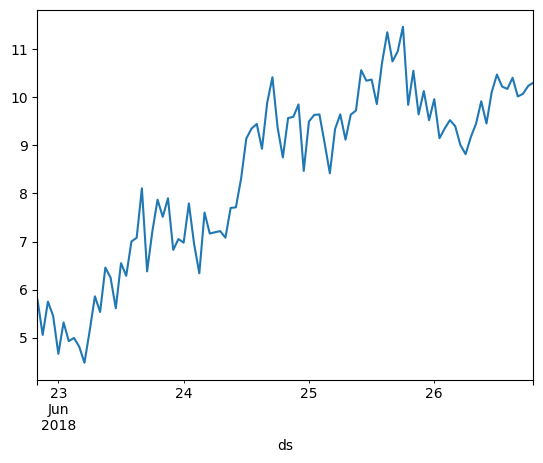

In [3]:
merged_df['MIXModel'].plot()

C:\Users\houyikai\AppData\Local\Temp\ipykernel_16472\1131333892.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  merged_df['smoothed_value'][0] = merged_df['MIXModel'][0]  # 初始值等于第一个数据点
C:\Users\houyikai\AppData\Local\Temp\ipykernel_16472\1131333892.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['smoothed_value'][0] = merged_df['MIXModel'][0]  # 初始值等于第一个数据点
C:\Users\houyikai\AppData\Local\Temp\ipykernel_16472\1131333892.py:3: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavio

<Axes: xlabel='ds'>

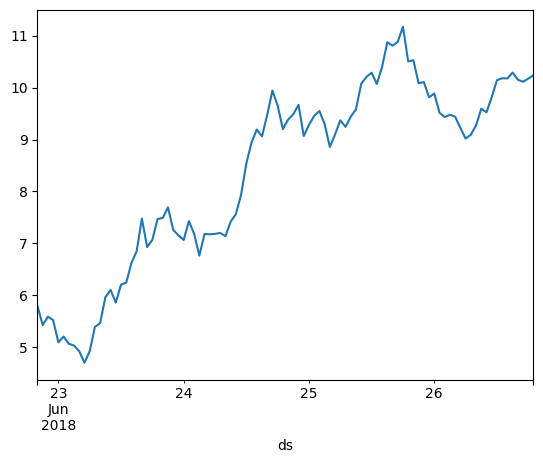

In [11]:
alpha = 0.5
merged_df['smoothed_value'] = np.nan
merged_df['smoothed_value'][0] = merged_df['MIXModel'][0]  # 初始值等于第一个数据点
for i in range(1, len(merged_df)):
    merged_df['smoothed_value'][i] = alpha * merged_df['MIXModel'][i] + (1 - alpha) * merged_df['smoothed_value'][i-1]
merged_df['smoothed_value'].plot() 

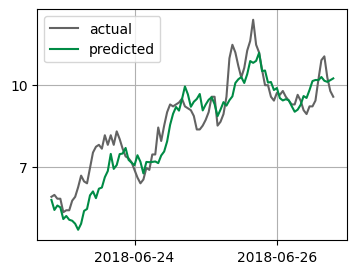

In [19]:
# dates = [merged_df.index[0] + datetime.timedelta(days=i) for i in range(30)]
import matplotlib.dates as mdates
plt.figure(figsize=(4, 3))
plt.grid(True)
# plt.xticks()

date_format = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)

date_locator = mdates.DayLocator(interval=2)  # 每隔5天显示一个日期
plt.gca().xaxis.set_major_locator(date_locator)

y_ticks = np.linspace(4, 13, 4)  
plt.yticks(y_ticks)

plt.plot(merged_df.index,merged_df["y"], label="actual",color = '#636363')
plt.plot(merged_df.index,merged_df["smoothed_value"], label="predicted",color = '#008B45')
plt.legend()
# plt.title('(a) PatchTST with DSP')
plt.show()

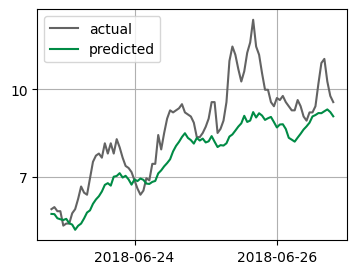

In [18]:
plt.figure(figsize=(4, 3))
plt.grid(True)
# plt.xticks()

date_format = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)

date_locator = mdates.DayLocator(interval=2)  # 每隔5天显示一个日期
plt.gca().xaxis.set_major_locator(date_locator)

y_ticks = np.linspace(4, 13, 4)  
plt.yticks(y_ticks)

plt.plot(merged_df.index,merged_df["y"], label="actual",color = '#636363')
plt.plot(merged_df.index,merged_df["NHITS"], label="predicted",color = '#008B45')
plt.legend()
# plt.title('(b) NHITS')
plt.show()

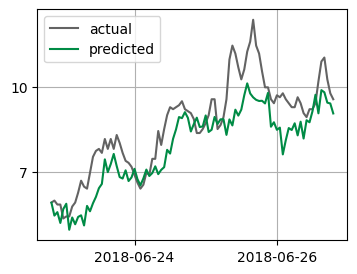

In [17]:
plt.figure(figsize=(4, 3))
plt.grid(True)
# plt.xticks()

date_format = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)

date_locator = mdates.DayLocator(interval=2)  # 每隔5天显示一个日期
plt.gca().xaxis.set_major_locator(date_locator)
y_ticks = np.linspace(4, 13, 4)  
plt.yticks(y_ticks)

plt.plot(merged_df.index,merged_df["y"], label="actual",color = '#636363')
plt.plot(merged_df.index,merged_df["PatchTST"], label="predicted",color = '#008B45')
plt.legend()
# plt.title('(c) PatchTST')
plt.show()